# Fundamental Matrix Estimation, Camera Calibration, Triangulation (Python)
## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Fundamental Matrix Estimation, Camera Calibration, Triangulation section of MP 3. We outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- `numpy`
- `PIL`

#### Common imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

#### Part (1)

In [2]:
def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual on frame 2
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.mean(np.square(pt_line_dist))

def plot_fundamental(ax, F, p1, p2, I):
    """
    Function to display epipolar lines and corresponding points
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    param: I: frame 2
    """
    N = p1.shape[0]
    P1 = np.c_[p1, np.ones((N,1))].transpose()
    P2 = np.c_[p2, np.ones((N,1))].transpose()
    L2 = np.matmul(F, P1).transpose() # transform points from 

    # the first image to get epipolar lines in the second image
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis=1)
    closest_pt = p2 - (L2[:,0:2]*pt_line_dist[:,np.newaxis])

    # Find endpoints of segment on epipolar line (for display purposes).
    # offset from the closest point is 10 pixels
    pt1 = closest_pt - np.c_[L2[:,1], -L2[:,0]]*10 
    pt2 = closest_pt + np.c_[L2[:,1], -L2[:,0]]*10

    # Display points and segments of corresponding epipolar lines.
    # You will see points in red corsses, epipolar lines in green 
    # and a short cyan line that denotes the shortest distance between
    # the epipolar line and the corresponding point.
    ax.set_aspect('equal')
    ax.imshow(np.array(I))
    ax.plot(p2[:,0],p2[:,1],  '+r')
    ax.plot([p2[:,0], closest_pt[:,0]],[p2[:,1], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')

In [102]:
# write your code here for part estimating essential matrices
def fit_fundamental(matches):
    """
    Solves for the fundamental matrix using the matches with unnormalized method.
    """
    # <YOUR CODE>
    x = matches[:, :2]
    x1 = matches[:, 2:]
    x = np.concatenate((x, np.ones((matches.shape[0], 1))), axis=1)
    H = np.zeros((x.shape[0], 9))
    H[:, :3] = x * x1[:, 0:1]
    H[:, 3:6] = x * x1[:, 1:2]
    H[:, 6:9] = x
    U, S, V = np.linalg.svd(H, full_matrices=False)
    F = V[-1, :].reshape(3, 3)
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    a = (U * S) @ V
    return (U * S) @ V

def fit_fundamental_normalized(matches):
    """
    Solve for the fundamental matrix using the matches with normalized method.
    """
    # <YOUR CODE>
    mean = np.mean(matches, axis=0)
    squared = np.mean((matches - mean)**2, axis=0)
    s0 = np.sqrt(np.sum(squared[:2]) / 2)
    s1 = np.sqrt(np.sum(squared[2:]) / 2)
    s0 = 1 / s0
    s1 = 1 / s1
    T0 = np.array([[s0, 0, -s0*mean[0]], [0, s0, -s0*mean[1]], [0, 0, 1]])
    T1 = np.array([[s1, 0, -s1*mean[2]], [0, s1, -s1*mean[3]], [0, 0, 1]])
    new_matches = matches - matches
    new_matches[:, :2] = (np.concatenate((matches[:, :2], np.ones((matches.shape[0], 1))), axis=1) @ (T0.T))[:, :2]
    new_matches[:, 2:] = (np.concatenate((matches[:, 2:], np.ones((matches.shape[0], 1))), axis=1) @ (T1.T))[:, :2]
    F = fit_fundamental(new_matches)
    return (T1.T) @ F @ (T0)

(309, 4) (309, 9) (309, 9) (9,) (9, 9)
library: residual in frame 2 (non-normalized method) =  0.17921336680315691
library: residual in frame 1 (non-normalized method) =  0.14912309938770843
library: residual combined   (non-normalized method) =  0.16416823309543266
(309, 4) (309, 9) (309, 9) (9,) (9, 9)
library: residual in frame 2 (normalized method) =  0.06025105258204402
library: residual in frame 1 (normalized method) =  0.054813634092204806
library: residual combined   (normalized method) =  0.05753234333712441


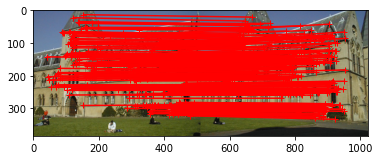

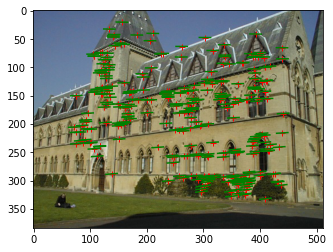

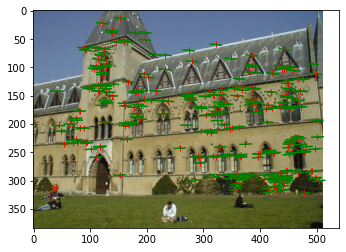

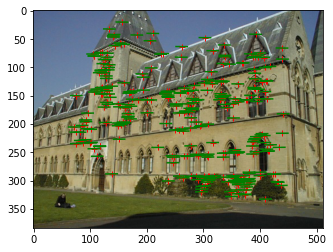

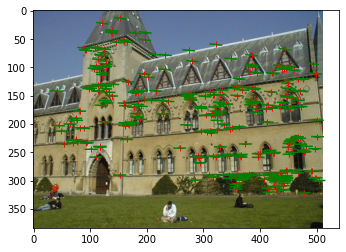

In [85]:
# Fundamental matrix estimation
name = 'library' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))

# non-normalized method
F = fit_fundamental(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig('unnormalized_I2.png')
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig('unnormalized_I1.png')

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig('normalized_I2.png')
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig('normalized_I1.png')

lab: residual in frame 2 (non-normalized method) =  6.567091502185167
lab: residual in frame 1 (non-normalized method) =  9.76065542496813
lab: residual combined   (non-normalized method) =  8.163873463576648
lab: residual in frame 2 (normalized method) =  0.5473984648841668
lab: residual in frame 1 (normalized method) =  0.5792257462301125
lab: residual combined   (normalized method) =  0.5633121055571396


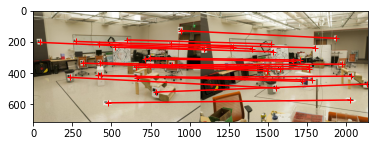

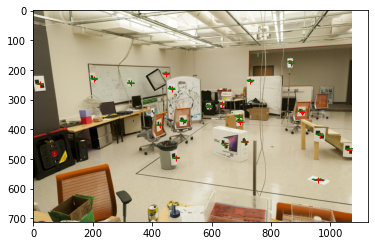

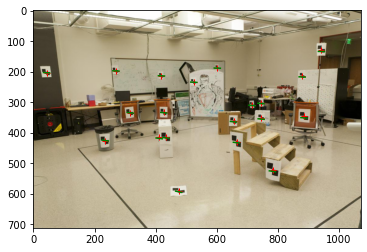

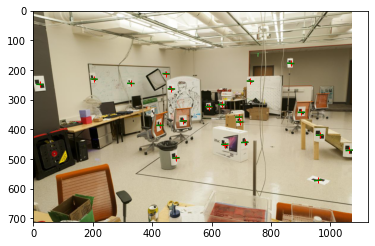

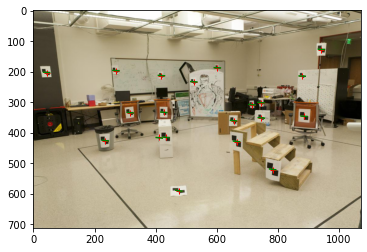

In [18]:
# Fundamental matrix estimation
name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))
fig.savefig('lab_vis.png')

# non-normalized method
F = fit_fundamental(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig('unnormalized_lab_I2.png')
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig('unnormalized_lab_I1.png')

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig('normalized_lab_I2.png')
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig('normalized_lab_I1.png')

#### Part (2)

In [20]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

# Write your code here for camera calibration (lab)
def camera_calibration(points, projection):
    """
    write your code to compute camera matrix
    """
    # <YOUR CODE>
    N = points.shape[0]
    points = np.concatenate((points, np.ones((N, 1))), axis=1)
    A = np.zeros((2*N, 12))
    zeros = np.zeros((4, ))
    ones = np.ones((4, ))
    for i in range(N):
        x1, y1 = projection[i]
        flatten = np.array([*zeros, *ones, *(-y1*ones), *ones, *zeros, *(-x1*ones)])
        A[2*i:2*i + 2] = (flatten.reshape(6, 4)*points[i]).reshape(2, 12)
    U, S, V = np.linalg.svd(A, full_matrices=False)
    P = V[-1, :].reshape(3, 4)
    return P

# Load 3D points, and their corresponding locations in 
# the two images.
pts_3d = np.loadtxt('./lab_3d.txt')
matches = np.loadtxt('./lab_matches.txt')

# <YOUR CODE> print lab camera projection matrices:
lab1_proj = camera_calibration(pts_3d, matches[:, :2])
lab2_proj = camera_calibration(pts_3d, matches[:, 2:])
print('lab 1 camera projection')
print(lab1_proj)

print('')
print('lab 2 camera projection')
print(lab2_proj)

# <YOUR CODE> evaluate the residuals for both estimated cameras
pts_3d_proj1, lab1_res = evaluate_points(lab1_proj, matches[:, :2], pts_3d)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in lab1:', lab1_res)
pts_3d_proj2, lab2_res = evaluate_points(lab2_proj, matches[:, 2:], pts_3d)
print('residual in lab2:', lab2_res)

lab 1 camera projection
[[-3.09963996e-03 -1.46204548e-04  4.48497465e-04  9.78930678e-01]
 [-3.07018252e-04 -6.37193664e-04  2.77356178e-03  2.04144405e-01]
 [-1.67933533e-06 -2.74767684e-06  6.83964827e-07  1.32882928e-03]]

lab 2 camera projection
[[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
residuals between the observed 2D points and the projected 3D points:
residual in lab1: 13.545832894770703
residual in lab2: 15.544953451653466


In [11]:
lib1_proj = np.loadtxt('./library1_camera.txt')
lib2_proj = np.loadtxt('./library2_camera.txt')
print('library1 camera projection')
print(lib1_proj)
print('library2 camera projection')
print(lib2_proj)

library1 camera projection
[[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
library2 camera projection
[[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]]


#### Part (3)

In [12]:
# Write your code here for computing camera centers
def calc_camera_center(P):
    """
    write your code to get camera center in the world 
    from the projection matrix
    """
    # <YOUR CODE>
    U, S, V = np.linalg.svd(P)
    C = V[-1, :]
    C /= C[-1]
    return C[:3]

# <YOUR CODE> compute the camera centers using 
# the projection matrices
lab1_c = calc_camera_center(lab1_proj)
lab2_c = calc_camera_center(lab2_proj)
print('lab1 camera center', lab1_c)
print('lab2 camera center', lab2_c)

# <YOUR CODE> compute the camera centers with the projection matrices
lib1_c = calc_camera_center(lib1_proj)
lib2_c = calc_camera_center(lib2_proj)
print('library1 camera center', lib1_c)
print('library2 camera center', lib2_c)

lab1 camera center [305.83276769 304.20103826  30.13699243]
lab2 camera center [303.10003925 307.18428016  30.42166874]
library1 camera center [  7.28863053 -21.52118112  17.73503585]
library2 camera center [  6.89405488 -15.39232716  23.41498687]


#### Part (4)

Mean 3D reconstuction error for the lab data:  0.00025
2D reprojection error for the lab 1 data:  10.899446030785167
2D reprojection error for the lab 2 data:  1.5485148055488542
2D reprojection error for the library 1 data:  24.662071196869373
2D reprojection error for the library 2 data:  28.649537735260907


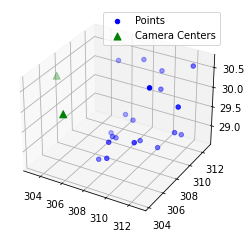

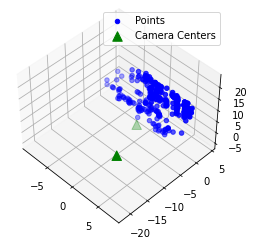

In [15]:
# Write your code here for triangulation
from mpl_toolkits.mplot3d import Axes3D
def triangulation(P1, P2, matches):
    """
    write your code to triangulate the points in 3D
    """
    # <YOUR CODE>
    N = matches.shape[0]
    triangulated = np.zeros((N, 3))
    for i in range(N):
        x1, y1, x2, y2 = matches[i]
        A1 = np.array([[0, 1, -y1], [1, 0, -x1]])
        A2 = np.array([[0, 1, -y2], [1, 0, -x2]])
        A = np.zeros((4, 4))
        A[:2, :] = A1 @ P1
        A[2:, :] = A2 @ P2
        U, S, V = np.linalg.svd(A)
        X = V[-1, :]
        X /= X[-1]
        triangulated[i, :] = X[:3]
    return triangulated

def evaluate_points_3d(output, gt):
    """
    write your code to evaluate the triangulated 3D points
    """
    # <YOUR CODE>
    return np.sum((output - gt)**2, axis=1)

# triangulate the 3D point cloud for the lab data 
matches_lab = np.loadtxt('./lab_matches.txt')
points_3d_gt = np.loadtxt('./lab_3d.txt')
points_3d_lab = triangulation(lab1_proj, lab2_proj, matches_lab) # <YOUR CODE>
res_3d_lab = evaluate_points_3d(points_3d_lab, points_3d_gt) # <YOUR CODE>
print('Mean 3D reconstuction error for the lab data: ', round(np.mean(res_3d_lab), 5))
_, res_2d_lab1 = evaluate_points(lab1_proj, matches[:, :2], points_3d_lab)
_, res_2d_lab2 = evaluate_points(lab2_proj, matches[:, 2:], points_3d_lab)
print('2D reprojection error for the lab 1 data: ', np.mean(res_2d_lab1))
print('2D reprojection error for the lab 2 data: ', np.mean(res_2d_lab2))
# visualization of lab point cloud
camera_centers = np.vstack((lab1_c, lab2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lab[:, 0], points_3d_lab[:, 1], points_3d_lab[:, 2], c='b', label='Points')
ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], c='g', s=50, marker='^', label='Camera Centers')
ax.legend(loc='best')
fig.savefig('triangulation1.png')

# triangulate the 3D point cloud for the library data
matches_lib = np.loadtxt('./library_matches.txt')
points_3d_lib = triangulation(lib1_proj, lib2_proj, matches_lib) # <YOUR CODE>
_, res_2d_lib1 = evaluate_points(lib1_proj, matches_lib[:, :2], points_3d_lib)
_, res_2d_lib2 = evaluate_points(lib2_proj, matches_lib[:, 2:], points_3d_lib)
print('2D reprojection error for the library 1 data: ', np.mean(res_2d_lib1))
print('2D reprojection error for the library 2 data: ', np.mean(res_2d_lib2))
# visualization of library point cloud
camera_centers_library = np.vstack((lib1_c, lib2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lib[:, 0], points_3d_lib[:, 1], points_3d_lib[:, 2], c='b', label='Points')
ax.scatter(camera_centers_library[:, 0], camera_centers_library[:, 1], 
           camera_centers_library[:, 2], c='g', s=90, 
           marker='^', label='Camera Centers')
ax.view_init(azim=-45, elev=45)
ax.legend(loc='best')
fig.savefig('triangulation2.png')

# Extra Credit

In [276]:
def get_best_matches(img1, img2, threshold=0.03):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    match = dist / dist.max() < threshold
    inliers = np.zeros((match.sum(), 4))
    idx = 0
    if kp1.shape[0] > kp2.shape[0]:
        for i in range(kp2.shape[0]):
            for j in range(i, kp1.shape[0]):
                if match[j, i]:
                    inliers[idx, :] = np.array([*kp1[j].pt, *kp2[i].pt])
                    idx += 1
    else:
        for i in range(kp1.shape[0]):
            for j in range(kp2.shape[0]):
                if match[i, j]:
                    inliers[idx, :] = np.array([*kp1[i].pt, *kp2[j].pt])
                    idx += 1
    return inliers

def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual on frame 2
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return (np.square(pt_line_dist))

def ransac(data, distance_threshold=2, outlier_ratio=0.2):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    # <YOUR CODE>
    threshold = distance_threshold
    p = 0.99
    s = 8
    e = outlier_ratio
    N = int(np.log(1 - p)/np.log(1 - (1 - e)**s))
    best_h = None
    inlier_residual = None
    best_inlier_indices = None
    min_residual = np.inf
    count = 0
    selected = None
    while count < N:
        selected = np.random.randint(0, data.shape[0], s)
        matches = data[selected]
        F = fit_fundamental_normalized(matches).reshape(3, 3)
        X1 = np.concatenate((data[:, :2], np.ones((data.shape[0], 1))), axis=1)
        X2 = np.concatenate((data[:, 2:], np.ones((data.shape[0], 1))), axis=1)
        residual = (get_residual(F, data[:, :2], data[:, 2:]) + get_residual(F.T, data[:, 2:], data[:, :2]))/2
        inlier_indices = residual <= threshold
        outliers = data[residual > threshold]
        inliers = data[inlier_indices]
        if outliers.shape[0] / data.shape[0] < e:
            print('Process finish due to outliers are less than assumed number.')
            inlier_residual = residual[inlier_indices]
            best_h = fit_fundamental_normalized(inliers).reshape(3, 3)
            return best_h, inliers, inlier_residual
        inlier_residual = np.mean(residual[inlier_indices])
        if inlier_residual < min_residual:
            min_residual = inlier_residual
            best_residual = residual[inlier_indices]
            best_indices = inlier_indices
        count += 1
    inliers = data[best_indices]
    best_h = fit_fundamental_normalized(inliers).reshape(3, 3)
    print('Fail to find a good model with given conditions!')
    return best_h, inliers, best_residual

In [277]:
import skimage
from skimage import io
import skimage.transform
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy

def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

(104, 4)


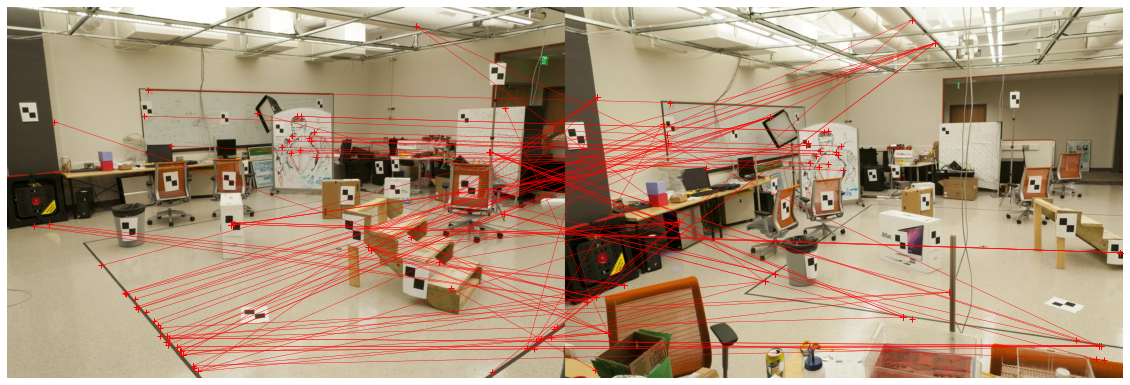

In [267]:
img1 = imread('./lab1.jpg')
img2 = imread('./lab2.jpg')

data = get_best_matches(img1, img2, threshold=0.01)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.png', bbox_inches='tight')
data = np.unique(data, axis=0)
print(data.shape)

In [278]:
# display the inlier matching, report the average residual
# <YOUR CODE>
F, max_inliers, best_model_errors = ransac(data, distance_threshold=2, outlier_ratio=0.9)
print("Average residual:", np.average(best_model_errors))
print("Inliers:", max_inliers)
fig.savefig('ransac_match_q2_lab.png', bbox_inches='tight')
print(max_inliers.shape)

C:\Users\12176\anaconda3\envs\hi\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\12176\anaconda3\envs\hi\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-276-4ec1f72b8a87>:39: RuntimeWarning: divide by zero encountered in true_divide
  L2 = L2 / L2_norm[:,np.newaxis]
<ipython-input-276-4ec1f72b8a87>:39: RuntimeWarning: invalid value encountered in true_divide
  L2 = L2 / L2_norm[:,np.newaxis]


Process finish due to outliers are less than assumed number.
Average residual: 0.14638664785463054
Inliers: [[ 180.61399841  495.70553589  709.4050293    68.92330933]
 [ 225.04483032  548.52972412  392.72283936  210.77639771]
 [ 225.04483032  548.52972412  709.4050293    68.92330933]
 [ 227.40086365  551.44946289  392.72283936  210.77639771]
 [ 247.29393005  575.49468994  709.4050293    68.92330933]
 [ 249.82696533  578.43499756  392.72283936  210.77639771]
 [ 249.82696533  578.43499756  709.4050293    68.92330933]
 [ 293.55612183  630.36724854  392.72283936  210.77639771]
 [ 304.25686646  642.89904785  392.72283936  210.77639771]
 [ 313.78564453  265.95431519  270.02111816  308.62097168]
 [ 930.5045166   700.52862549  218.07025146  412.072052  ]
 [ 953.19287109  397.04449463 1024.25048828  649.8762207 ]]
(12, 4)


lab: residual in frame 2 (normalized method) =  0.00010078826643499264
lab: residual in frame 1 (normalized method) =  0.015038726701158779
lab: residual combined   (normalized method) =  0.007569757483796886


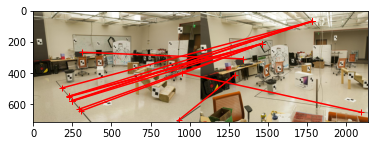

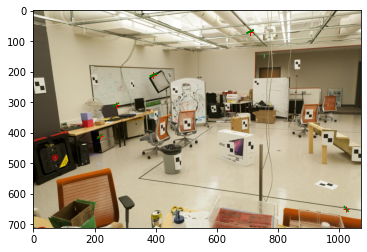

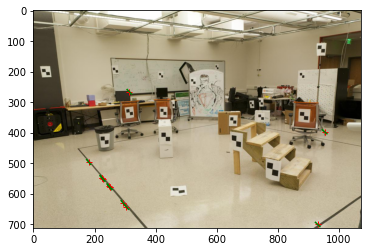

In [279]:
# Fundamental matrix estimation
name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))

matches = max_inliers
## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))
fig.savefig('lab_vis_extra.png')

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = np.mean(get_residual(F, pt1_2d, pt2_2d))
v1 = np.mean(get_residual(F.T, pt2_2d, pt1_2d))
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig('normalized_lab_I2_extra.png')
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig('normalized_lab_I1_extra.png')

(121, 4)


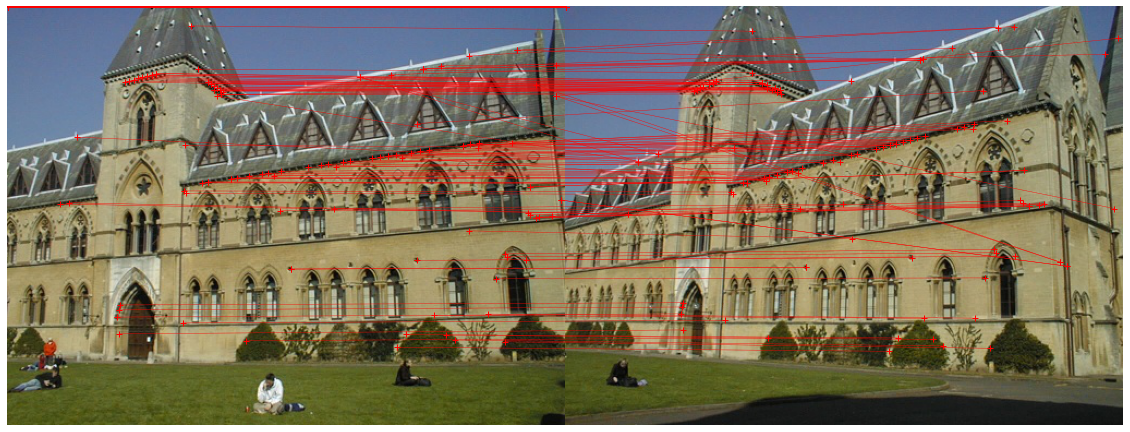

In [280]:
img1 = imread('./library1.jpg')
img2 = imread('./library2.jpg')

data = get_best_matches(img1, img2, threshold=0.03)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match_library.png', bbox_inches='tight')
data = data[np.sum(data, axis=1) != 0]
print(data.shape)

In [281]:
# display the inlier matching, report the average residual
# <YOUR CODE>
F, max_inliers, best_model_errors = ransac(data, distance_threshold=2, outlier_ratio=0.8)
print("Average residual:", np.average(best_model_errors))
print("Inliers:", max_inliers)
fig.savefig('ransac_match_q2_lab.png', bbox_inches='tight')
print(max_inliers.shape)

Process finish due to outliers are less than assumed number.
Average residual: 0.5184247077029533
Inliers: [[119.48255157  65.65357971 123.16197968  74.91950989]
 [123.20146179  64.68534088 126.1443634   73.61240387]
 [127.57256317  63.54036331 131.70808411  70.86852264]
 [131.99316406  62.40341187 131.70808411  70.86852264]
 [131.99316406  62.40341187 134.80178833  69.42327118]
 [136.37637329  61.18081284 137.59104919  67.90045929]
 [178.31262207 161.53799438 162.81323242 162.08732605]
 [183.41427612 160.75514221 166.55943298 161.35464478]
 [183.41427612 160.75514221 166.55943298 161.35464478]
 [174.11605835  57.08974838 170.55082703  60.52401352]
 [204.50993347 157.58198547 181.98857117 157.19487   ]
 [210.14569092 156.77050781 186.12542725 156.13856506]
 [243.93000793 154.87997437 212.67884827 152.29133606]
 [323.10018921  64.66329956 261.96173096  68.0096283 ]
 [307.72702026 142.56428528 262.12832642 136.2056427 ]
 [314.07696533 141.66116333 267.57183838 134.89888   ]
 [334.6034545

library: residual in frame 2 (normalized method) =  0.3296226383311854
library: residual in frame 1 (normalized method) =  0.3414335406864087
library: residual combined   (normalized method) =  0.33552808950879703


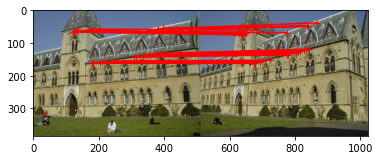

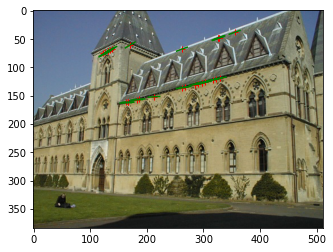

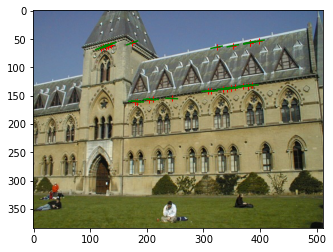

In [282]:
# Fundamental matrix estimation
name = 'library'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))

matches = max_inliers
## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))
fig.savefig('library_vis_extra.png')

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = np.mean(get_residual(F, pt1_2d, pt2_2d))
v1 = np.mean(get_residual(F.T, pt2_2d, pt1_2d))
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig('normalized_library_I2_extra.png')
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig('normalized_library_I1_extra.png')